In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import ast
import matplotlib.ticker as mticker

In [2]:
movies = pd.read_csv('../data/movies_2015_2024.csv')
movies.head(3)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,365000000,1405403694,99861
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,150000000,378858340,76341
2,Inside Out,2015,"['Animation', 'Family', 'Adventure', 'Drama', ...",7.910,22924,175000000,857611174,150540


In [3]:
best_picture = pd.read_csv('../data/best_picture.csv')
best_picture.head(3) #add column that labels it as nominee

,Title,Awards_Year,Winner
0,Wings,1928,Yes
1,7th Heaven,1928,No
2,The Racket,1928,No


In [4]:
cpi_data = pd.read_csv('../data/CPI_data.csv').set_index('Year')
budget_2024 = []
for year,budget in zip(movies['Year'], movies['Budget']):
    budget_adjusted = budget*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    budget_2024.append(budget_adjusted)
# Reassign adjusted budget numbers to the Budget column
movies['Budget'] = budget_2024
revenue_2024 = []
for year,revenue in zip(movies['Year'], movies['Revenue']):
    revenue_adjusted = revenue*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    revenue_2024.append(revenue_adjusted)
# Reassign adjusted budget numbers to the Revenue column
movies['Revenue'] = revenue_2024

movies = movies[(movies['Revenue']!=0) | (movies['Budget']!=0)]

In [5]:
best_picture['Nominee'] = 'Yes'
best_picture = best_picture.rename(columns = {'Awards_Year' : 'Year'})
best_picture

,Title,Year,Winner,Nominee
0,Wings,1928,Yes,Yes
1,7th Heaven,1928,No,Yes
2,The Racket,1928,No,Yes
3,The Broadway Melody,1929,Yes,Yes
4,Alibi,1929,No,Yes
...,...,...,...,...
606,Emilia Pérez,2024,No,Yes
607,I'm Still Here,2024,No,Yes
608,Nickel Boys,2024,No,Yes
609,The Substance,2024,No,Yes


In [6]:
merged_movies = movies.merge(best_picture, how = 'outer', on=['Title','Year'])
merged_movies = merged_movies[merged_movies['Year']>=2015]

# Fill NaN values
values = {'Winner': 'No', 'Nominee': 'No'}
merged_movies = merged_movies.fillna(value=values)

merged_movies

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Winner,Nominee
0,#Alive,2020,"['Action', 'Horror', 'Science Fiction']",7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No
1,10 Cloverfield Lane,2016,"['Thriller', 'Science Fiction', 'Drama', 'Horr...",6.994,8359.0,1.960499e+07,1.440535e+08,333371.0,No,No
3,12 Strong,2018,"['War', 'Drama', 'Action', 'History']",6.346,3097.0,4.372286e+07,8.426121e+07,429351.0,No,No
6,13 Hours: The Secret Soldiers of Benghazi,2016,"['War', 'Action', 'History', 'Drama', 'Thriller']",7.269,3789.0,6.534997e+07,9.072062e+07,300671.0,No,No
7,1917,2019,"['War', 'History', 'Drama', 'Action']",8.000,13092.0,1.226992e+08,5.473172e+08,530915.0,No,Yes
...,...,...,...,...,...,...,...,...,...,...
1412,Zack Snyder's Justice League,2021,"['Action', 'Adventure', 'Fantasy']",8.103,10482.0,8.103565e+07,0.000000e+00,791373.0,No,No
1414,Zombieland: Double Tap,2019,"['Horror', 'Comedy']",6.912,6022.0,5.153365e+07,1.506873e+08,338967.0,No,No
1415,Zootopia,2016,"['Animation', 'Adventure', 'Family', 'Comedy']",7.800,17070.0,1.960499e+08,1.340356e+09,269149.0,No,No
1417,mother!,2017,"['Drama', 'Horror']",6.967,6911.0,3.839209e+07,5.697003e+07,381283.0,No,No


## Do Best Picture nominees or winners tend to earn higher box-office revenue than non-nominated movies?

In [7]:
merged_movies['Nominee'].value_counts()


Nominee
No     808
Yes     91
Name: count, dtype: int64

In [8]:
# First calculate the mean revenue grouped by Winner status
revenue_nominee = merged_movies.groupby(merged_movies['Nominee'] == 'Yes').agg({'Revenue': 'median'})

# Then format the numbers properly - apply formatting to each value individually
revenue_nominee = revenue_nominee.map(lambda x: f'${x:,.0f}')
revenue_nominee

,Revenue
Nominee,
False,"$119,299,083"
True,"$101,188,411"


## The results show that there is a higher average revenue for nominated movies.

x= nominee- predictor
y= revenue- target

maybe include genre, year, etc.?

statistical research to predict the increase level of revenue if it is nominated

In [9]:
merged_movies["Nominee_bin"] = merged_movies["Nominee"].map({"Yes": 1, "No": 0})

lr_nominees = smf.ols("Revenue ~ Nominee_bin", data=merged_movies).fit()
lr_nominees.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2672
Date:                Mon, 24 Nov 2025   Prob (F-statistic):              0.605
Time:                        15:41:13   Log-Likelihood:                -18940.
No. Observations:                 893   AIC:                         3.788e+04
Df Residuals:                     891   BIC:                         3.789e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.606e+08   1.39e+07     18.802      0.000    2.33e+08    2.88e+08
Nominee_bin  2.322e+07   4.49e+07      0.517      0.605   -6.49e+07    1.11e+08
==============================================================================
Omnibus:                      599.868   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6783.222
Skew:                           3.000   Prob(JB):                         0.00
Kurtosis:                      15.095   Cond. No.                         3.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
lr_winner = smf.ols("Revenue ~ Winner", data=merged_movies).fit()
lr_winner.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 2.969e-05
Date:                Mon, 24 Nov 2025   Prob (F-statistic):              0.996
Time:                        15:41:14   Log-Likelihood:                -18940.
No. Observations:                 893   AIC:                         3.788e+04
Df Residuals:                     891   BIC:                         3.789e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.628e+08   1.33e+07     19.829      0.000    2.37e+08    2.89e+08
Winner[T.Yes]  7.192e+05   1.32e+08      0.005      0.996   -2.58e+08     2.6e+08
==============================================================================
Omnibus:                      600.377   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6795.954
Skew:                           3.004   Prob(JB):                         0.00
Kurtosis:                      15.106   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
merged_movies['Genre'] = merged_movies['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
movies_exploded = merged_movies.explode('Genre', ignore_index = False)
movies_exploded

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Winner,Nominee,Nominee_bin
0,#Alive,2020,Action,7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No,0
0,#Alive,2020,Horror,7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No,0
0,#Alive,2020,Science Fiction,7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No,0
1,10 Cloverfield Lane,2016,Thriller,6.994,8359.0,1.960499e+07,1.440535e+08,333371.0,No,No,0
1,10 Cloverfield Lane,2016,Science Fiction,6.994,8359.0,1.960499e+07,1.440535e+08,333371.0,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...
1417,mother!,2017,Drama,6.967,6911.0,3.839209e+07,5.697003e+07,381283.0,No,No,0
1417,mother!,2017,Horror,6.967,6911.0,3.839209e+07,5.697003e+07,381283.0,No,No,0
1418,xXx: Return of Xander Cage,2017,Action,6.100,9120.0,1.087776e+08,4.429402e+08,47971.0,No,No,0
1418,xXx: Return of Xander Cage,2017,Adventure,6.100,9120.0,1.087776e+08,4.429402e+08,47971.0,No,No,0


In [12]:
# Create an indicator variable for each genre
genre_dummies = pd.get_dummies(movies_exploded['Genre'], prefix='genre')

# Group the genre indicator variables so that we have 1 row per movie
genre_dummies_grouped = genre_dummies.groupby(level=0).max()

# Replace spaces in column names with underscores
genre_dummies_grouped.columns = [column.replace(' ','_') for column in genre_dummies_grouped.columns]

# Join the genre indicator variables to the movies_df DataFrame
movies_genre_indicator = merged_movies.join(genre_dummies_grouped)

# Fitting a linear regression model for vote_average using years and each of the genre indicator variables
# Extract all of the genre indicator variables and concatenate them with plus signs to be used in the linear model
genre_indicators = [column for column in movies_genre_indicator.columns if 'genre_' in column]
genre_indicators = ' + '.join(genre_indicators)

In [13]:
lr_genre = smf.ols(f"Revenue ~ Nominee + {genre_indicators}", data=movies_genre_indicator).fit()
lr_genre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     15.07
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           1.89e-40
Time:                        15:41:14   Log-Likelihood:                -18820.
No. Observations:                 893   AIC:                         3.768e+04
Df Residuals:                     874   BIC:                         3.777e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.997e+08   4.71e+07      4.237      0.000    1.07e+08    2.92e+08
Nominee[T.Yes]                 1.729e+08   4.41e+07      3.917      0.000    8.63e+07    2.59e+08
genre_Action[T.True]            9.87e+07   3.35e+07      2.950      0.003     3.3e+07    1.64e+08
genre_Adventure[T.True]        1.969e+08   3.39e+07      5.801      0.000     1.3e+08    2.63e+08
genre_Animation[T.True]        5.513e+07   5.59e+07      0.986      0.324   -5.46e+07    1.65e+08
genre_Comedy[T.True]          -6.221e+07   3.22e+07     -1.934      0.053   -1.25e+08    9.18e+05
genre_Crime[T.True]            5.753e+06   3.81e+07      0.151      0.880    -6.9e+07    8.05e+07
genre_Drama[T.True]           -1.035e+08   3.52e+07     -2.940      0.003   -1.73e+08   -3.44e+07
genre_Family[T.True]           1.728e+08   5.56e+07      3.106      0.002    6.36e+07    2.82e+08
genre_Fantasy[T.True]         -4.331e+07   3.66e+07     -1.182      0.237   -1.15e+08    2.86e+07
genre_History[T.True]         -6.886e+07   5.29e+07     -1.302      0.193   -1.73e+08    3.49e+07
genre_Horror[T.True]          -6.435e+07   4.02e+07     -1.601      0.110   -1.43e+08    1.45e+07
genre_Music[T.True]            6.195e+07   7.73e+07      0.802      0.423   -8.97e+07    2.14e+08
genre_Mystery[T.True]         -4.925e+07   4.25e+07     -1.159      0.247   -1.33e+08    3.42e+07
genre_Romance[T.True]          2.238e+07   4.25e+07      0.527      0.598    -6.1e+07    1.06e+08
genre_Science_Fiction[T.True]  8.158e+07    3.4e+07      2.398      0.017    1.48e+07    1.48e+08
genre_Thriller[T.True]        -5.292e+07   3.21e+07     -1.650      0.099   -1.16e+08       1e+07
genre_War[T.True]             -5.419e+07   8.05e+07     -0.673      0.501   -2.12e+08    1.04e+08
genre_Western[T.True]         -8.515e+07   1.34e+08     -0.635      0.526   -3.48e+08    1.78e+08
==============================================================================
Omnibus:                      534.945   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6092.593
Skew:                           2.550   Prob(JB):                         0.00
Kurtosis:                      14.736   Cond. No.                         15.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
revenue_nominee = merged_movies.groupby(merged_movies['Nominee'] == 'Yes').agg({'Revenue': 'median'})
revenue_nominee

,Revenue
Nominee,
False,1.192991e+08
True,1.011884e+08


In [15]:
movies_exploded

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Winner,Nominee,Nominee_bin
0,#Alive,2020,Action,7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No,0
0,#Alive,2020,Horror,7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No,0
0,#Alive,2020,Science Fiction,7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,No,No,0
1,10 Cloverfield Lane,2016,Thriller,6.994,8359.0,1.960499e+07,1.440535e+08,333371.0,No,No,0
1,10 Cloverfield Lane,2016,Science Fiction,6.994,8359.0,1.960499e+07,1.440535e+08,333371.0,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...
1417,mother!,2017,Drama,6.967,6911.0,3.839209e+07,5.697003e+07,381283.0,No,No,0
1417,mother!,2017,Horror,6.967,6911.0,3.839209e+07,5.697003e+07,381283.0,No,No,0
1418,xXx: Return of Xander Cage,2017,Action,6.100,9120.0,1.087776e+08,4.429402e+08,47971.0,No,No,0
1418,xXx: Return of Xander Cage,2017,Adventure,6.100,9120.0,1.087776e+08,4.429402e+08,47971.0,No,No,0


In [16]:
merged_movies['Nominee'] = merged_movies['Nominee'].replace({'Yes':True, 'No':False})
merged_movies['Winner'] = merged_movies['Winner'].replace({'Yes':True, 'No':False})
merged_movies['Oscar_Status'] = merged_movies['Nominee'].astype(int) + merged_movies['Winner'].astype(int)
merged_movies['Oscar_Status'] = merged_movies['Oscar_Status'].astype(int).replace({0: 'Not Nominated', 1: 'Nominated', 2: 'Winner'})
merged_movies.loc[merged_movies['Winner']]

/var/folders/h8/51mqc9v517x00_mhcb5s7ncw0000gn/T/ipykernel_54896/1053585733.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_movies['Nominee'] = merged_movies['Nominee'].replace({'Yes':True, 'No':False})
/var/folders/h8/51mqc9v517x00_mhcb5s7ncw0000gn/T/ipykernel_54896/1053585733.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_movies['Winner'] = merged_movies['Winner'].replace({'Yes':True, 'No':False})


,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Winner,Nominee,Nominee_bin,Oscar_Status
103,Anora,2024,"[Drama, Comedy, Romance]",7.050,2730.0,6.000000e+06,5.628630e+07,1064213.0,True,True,1,Winner
218,CODA,2021,"[Drama, Music, Romance]",7.903,2426.0,1.157652e+07,2.205394e+06,776503.0,True,True,1,Winner
359,Everything Everywhere All at Once,2022,"[Action, Adventure, Science Fiction]",7.728,7443.0,2.679683e+07,1.492047e+08,545611.0,True,True,1,Winner
456,Green Book,2018,"[Drama, Comedy, History]",8.224,12370.0,2.873216e+07,4.019413e+08,490132.0,True,True,1,Winner
719,Moonlight,2016,[Drama],7.400,7317.0,5.227998e+06,8.501598e+07,376867.0,True,True,1,Winner
761,Nomadland,2020,NaN,NaN,NaN,NaN,NaN,NaN,True,True,1,Winner
784,Oppenheimer,2023,"[Drama, History]",8.045,10956.0,1.029494e+08,9.800787e+08,872585.0,True,True,1,Winner
795,Parasite,2019,"[Comedy, Thriller, Drama]",8.500,19707.0,1.394231e+07,3.160630e+08,496243.0,True,True,1,Winner
953,Spotlight,2015,"[Drama, History]",7.800,8541.0,2.646975e+07,1.306153e+08,314365.0,True,True,1,Winner
1248,The Shape of Water,2017,"[Drama, Fantasy, Romance]",7.240,12533.0,2.495486e+07,2.499325e+08,399055.0,True,True,1,Winner


In [17]:
movies_genre_indicator['Nominee'] = movies_genre_indicator['Nominee'].replace({'Yes':True, 'No':False})
movies_genre_indicator['Winner'] = movies_genre_indicator['Winner'].replace({'Yes':True, 'No':False})
movies_genre_indicator['Oscar_Status'] = movies_genre_indicator['Nominee'].astype(int) + movies_genre_indicator['Winner'].astype(int)
movies_genre_indicator['Oscar_Status'] = movies_genre_indicator['Oscar_Status'].astype(int).replace({0: 'Not Nominated', 1: 'Nominated', 2: 'Winner'})
movies_genre_indicator.loc[movies_genre_indicator['Winner']]

/var/folders/h8/51mqc9v517x00_mhcb5s7ncw0000gn/T/ipykernel_54896/887650866.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movies_genre_indicator['Nominee'] = movies_genre_indicator['Nominee'].replace({'Yes':True, 'No':False})
/var/folders/h8/51mqc9v517x00_mhcb5s7ncw0000gn/T/ipykernel_54896/887650866.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movies_genre_indicator['Winner'] = movies_genre_indicator['Winner'].replace({'Yes':True, 'No':False})


,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Winner,Nominee,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_Thriller,genre_War,genre_Western,Oscar_Status
103,Anora,2024,"[Drama, Comedy, Romance]",7.050,2730.0,6.000000e+06,5.628630e+07,1064213.0,True,True,...,False,False,False,False,True,False,False,False,False,Winner
218,CODA,2021,"[Drama, Music, Romance]",7.903,2426.0,1.157652e+07,2.205394e+06,776503.0,True,True,...,False,False,True,False,True,False,False,False,False,Winner
359,Everything Everywhere All at Once,2022,"[Action, Adventure, Science Fiction]",7.728,7443.0,2.679683e+07,1.492047e+08,545611.0,True,True,...,False,False,False,False,False,True,False,False,False,Winner
456,Green Book,2018,"[Drama, Comedy, History]",8.224,12370.0,2.873216e+07,4.019413e+08,490132.0,True,True,...,True,False,False,False,False,False,False,False,False,Winner
719,Moonlight,2016,[Drama],7.400,7317.0,5.227998e+06,8.501598e+07,376867.0,True,True,...,False,False,False,False,False,False,False,False,False,Winner
761,Nomadland,2020,NaN,NaN,NaN,NaN,NaN,NaN,True,True,...,False,False,False,False,False,False,False,False,False,Winner
784,Oppenheimer,2023,"[Drama, History]",8.045,10956.0,1.029494e+08,9.800787e+08,872585.0,True,True,...,True,False,False,False,False,False,False,False,False,Winner
795,Parasite,2019,"[Comedy, Thriller, Drama]",8.500,19707.0,1.394231e+07,3.160630e+08,496243.0,True,True,...,False,False,False,False,False,False,True,False,False,Winner
953,Spotlight,2015,"[Drama, History]",7.800,8541.0,2.646975e+07,1.306153e+08,314365.0,True,True,...,True,False,False,False,False,False,False,False,False,Winner
1248,The Shape of Water,2017,"[Drama, Fantasy, Romance]",7.240,12533.0,2.495486e+07,2.499325e+08,399055.0,True,True,...,False,False,False,False,True,False,False,False,False,Winner


In [18]:
lr_genre = smf.ols(f"Revenue ~ C(Oscar_Status, Treatment('Not Nominated')) + {genre_indicators}", data=movies_genre_indicator).fit()
lr_genre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     14.26
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           7.35e-40
Time:                        15:41:14   Log-Likelihood:                -18820.
No. Observations:                 893   AIC:                         3.768e+04
Df Residuals:                     873   BIC:                         3.777e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                 1.994e+08   4.72e+07      4.225      0.000    1.07e+08    2.92e+08
C(Oscar_Status, Treatment('Not Nominated'))[T.Nominated]  1.751e+08    4.6e+07      3.804      0.000    8.48e+07    2.65e+08
C(Oscar_Status, Treatment('Not Nominated'))[T.Winner]     1.537e+08   1.19e+08      1.295      0.196   -7.92e+07    3.87e+08
genre_Action[T.True]                                      9.888e+07   3.35e+07      2.952      0.003    3.31e+07    1.65e+08
genre_Adventure[T.True]                                   1.969e+08    3.4e+07      5.799      0.000     1.3e+08    2.64e+08
genre_Animation[T.True]                                   5.514e+07   5.59e+07      0.986      0.325   -5.47e+07    1.65e+08
genre_Comedy[T.True]                                     -6.198e+07   3.22e+07     -1.925      0.055   -1.25e+08    1.22e+06
genre_Crime[T.True]                                       5.544e+06   3.81e+07      0.145      0.884   -6.93e+07    8.04e+07
genre_Drama[T.True]                                      -1.034e+08   3.52e+07     -2.936      0.003   -1.72e+08   -3.43e+07
genre_Family[T.True]                                      1.727e+08   5.57e+07      3.104      0.002    6.35e+07    2.82e+08
genre_Fantasy[T.True]                                    -4.315e+07   3.67e+07     -1.177      0.240   -1.15e+08    2.88e+07
genre_History[T.True]                                    -6.851e+07    5.3e+07     -1.294      0.196   -1.72e+08    3.54e+07
genre_Horror[T.True]                                     -6.424e+07   4.02e+07     -1.598      0.111   -1.43e+08    1.47e+07
genre_Music[T.True]                                       6.218e+07   7.73e+07      0.804      0.422   -8.96e+07    2.14e+08
genre_Mystery[T.True]                                    -4.922e+07   4.25e+07     -1.158      0.247   -1.33e+08    3.42e+07
genre_Romance[T.True]                                      2.28e+07   4.26e+07      0.535      0.592   -6.08e+07    1.06e+08
genre_Science_Fiction[T.True]                             8.162e+07    3.4e+07      2.398      0.017    1.48e+07    1.48e+08
genre_Thriller[T.True]                                   -5.274e+07   3.21e+07     -1.643      0.101   -1.16e+08    1.03e+07
genre_War[T.True]                                        -5.484e+07   8.06e+07     -0.680      0.496   -2.13e+08    1.03e+08
genre_Western[T.True]                                    -8.566e+07   1.34e+08     -0.638      0.524   -3.49e+08    1.78e+08
==============================================================================
Omnibus:                      534.926   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Ber

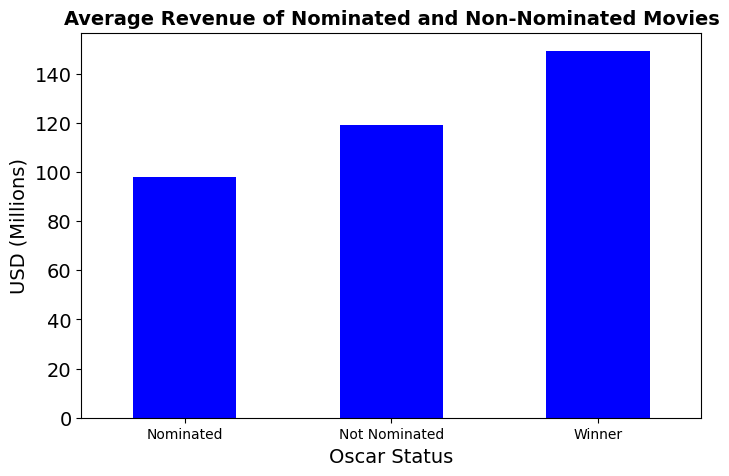

In [19]:
merged_movies['Revenue Millions'] = (merged_movies['Revenue'] / 1000000)

fig, ax = plt.subplots(figsize = (8,5))
merged_movies.groupby('Oscar_Status')['Revenue Millions'].median().plot(kind = 'bar', color = 'blue')
plt.xticks(rotation = 0)
plt.yticks(fontsize = 14)
plt.ylabel('Revenue', fontsize = 14)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set(ylabel='USD (Millions)')
plt.xlabel('Oscar Status', fontsize = 14)
plt.title('Average Revenue of Nominated and Non-Nominated Movies', fontsize = 14, fontweight = 'bold');


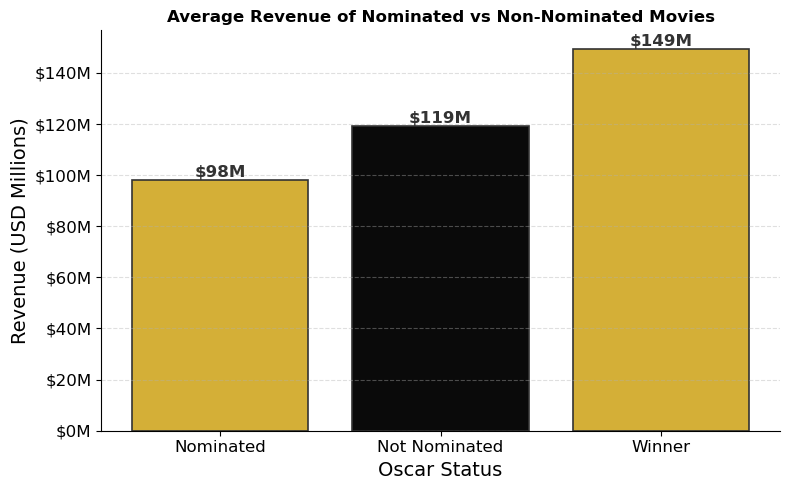

In [21]:
#same data with a nicer graph for presentation

fig, ax = plt.subplots(figsize=(8, 5))

# Compute the data
revenue_data = (
    merged_movies
    .groupby('Oscar_Status')['Revenue Millions']
    .median()
)

# Oscar-themed colors (matte black + metallic gold)
colors = ['#D4AF37', '#0A0A0A']   # deep black + Oscar gold

# Plot
bars = ax.bar(
    revenue_data.index,
    revenue_data.values,
    color=colors,
    edgecolor='#333333',
    linewidth=1.2
)

# Format y-axis as dollars
ax.yaxis.set_major_formatter(
    mticker.StrMethodFormatter('${x:,.0f}M')
)

# Value labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'${height:,.0f}M',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='#333333'
    )

# Title and labels
ax.set_title(
    'Average Revenue of Nominated vs Non-Nominated Movies',
    fontsize=12,
    fontweight='bold'
)

ax.set_xlabel('Oscar Status', fontsize=14)
ax.set_ylabel('Revenue (USD Millions)', fontsize=14)

# Style tweaks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(
    '../assets/Average_Revenue_of_Nominated_and_Non-Nominated_Movies_Oscar',
    dpi=150
)
plt.show()
